In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.decomposition import PCA
import statsmodels.api as sm

In [15]:
import pandas as pd

# Read the data from the file into a DataFrame
bejaia = pd.read_csv('Bejaia.csv')
sidi = pd.read_csv('Sidi.csv')

# These files contain the following columns:
#   - day: the date of the observation
#   - month: the month of the observation
#   - year: the year of the observation
#   - temperature noon (temperature max) in Celsius degrees: 22 to 42
#   - RH: Relative Humidity in %: 21 to 90
#   - Ws: Wind speed in km/h: 6 to 29
#   - Rain: total day in mm: 0 to 16.8
#   - FFMC: Fine Fuel Moisture Code (FFMC) index from the FWI system: 28.6 to 92.5
#   - DMC: Duff Moisture Code (DMC) index from the FWI system: 1.1 to 65.9
#          DCDrought Code (DC) index from the FWI system: 7 to 220.4

# Print the first five rows of the DataFrame
print(bejaia.head())
print("----")
print(sidi.head())

   day  month  year  Temperature  RH  Ws  Rain  FFMC  DMC    DC  ISI  BUI  \
0    1      6  2012           29  57  18   0.0  65.7  3.4   7.6  1.3  3.4   
1    2      6  2012           29  61  13   1.3  64.4  4.1   7.6  1.0  3.9   
2    3      6  2012           26  82  22  13.1  47.1  2.5   7.1  0.3  2.7   
3    4      6  2012           25  89  13   2.5  28.6  1.3   6.9  0.0  1.7   
4    5      6  2012           27  77  16   0.0  64.8  3.0  14.2  1.2  3.9   

   FWI   Classes  
0  0.5  not fire  
1  0.4  not fire  
2  0.1  not fire  
3  0.0  not fire  
4  0.5  not fire  
----
   day  month  year  Temperature  RH  Ws  Rain  FFMC  DMC    DC  ISI  BUI  \
0    1      6  2012           32  71  12   0.7  57.1  2.5   8.2  0.6  2.8   
1    2      6  2012           30  73  13   4.0  55.7  2.7   7.8  0.6  2.9   
2    3      6  2012           29  80  14   2.0  48.7  2.2   7.6  0.3  2.6   
3    4      6  2012           30  64  14   0.0  79.4  5.2  15.4  2.2  5.6   
4    5      6  2012           32 

In [3]:
# clean the data (clean the space in rows and columns; clean the none data)
bejaia.columns = bejaia.columns.str.strip()
display(bejaia.columns)
bejaia.dropna(inplace=True)
sidi.columns = sidi.columns.str.strip()
display(sidi.columns)
sidi.dropna(inplace=True)

bejaia.Classes = bejaia.Classes.str.strip()
display(bejaia.Classes.unique())
sidi.Classes = sidi.Classes.str.strip()
display(sidi.Classes.unique())

# drop the year column
bejaia = bejaia.drop(['year'], axis = 1)
sidi = sidi.drop(['year'], axis=1)

# divide the natural factors and FWI indices
natural_bejaia = bejaia[['Temperature', 'RH', 'Ws', 'Rain']]
fwi_bejaia = bejaia[['FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']]
natural_sidi = bejaia[['Temperature', 'RH', 'Ws', 'Rain']]
fwi_sidi = bejaia[['FFMC', 'DMC', 'DC', 'ISI', 'BUI', 'FWI']]

# recode the class as a dumby variable (not fire: 0, fire: 1)
replacement_mapping = {'fire': 1, 'not fire': 0}
bejaia['Classes'] = bejaia['Classes'].replace(replacement_mapping)
sidi['Classes'] = sidi['Classes'].replace(replacement_mapping)

dep_bejaia = bejaia['Classes']
dep_sidi = sidi['Classes']

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes'],
      dtype='object')

Index(['day', 'month', 'year', 'Temperature', 'RH', 'Ws', 'Rain', 'FFMC',
       'DMC', 'DC', 'ISI', 'BUI', 'FWI', 'Classes'],
      dtype='object')

array(['not fire', 'fire'], dtype=object)

array(['not fire', 'fire'], dtype=object)

In [4]:
# get the coefficient matrix
display(bejaia.corr())
display(sidi.corr())

,day,month,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
day,1.000000e+00,5.358691e-17,0.181092,-0.210608,0.063970,-0.097489,0.291751,0.542760,0.568644,0.371489,0.557301,0.467585,0.306384
month,5.358691e-17,1.000000e+00,-0.035708,-0.088025,-0.007804,0.145180,-0.040746,-0.007624,-0.006211,-0.011281,-0.009113,0.003330,-0.066455
Temperature,1.810918e-01,-3.570824e-02,1.000000,-0.660151,-0.228035,-0.486947,0.748423,0.541489,0.532838,0.663871,0.542210,0.608367,0.497810
RH,-2.106080e-01,-8.802546e-02,-0.660151,1.000000,0.245774,0.329163,-0.653153,-0.347080,-0.314271,-0.586410,-0.338233,-0.476067,-0.377328
Ws,6.396952e-02,-7.803641e-03,-0.228035,0.245774,1.000000,0.349321,-0.211069,0.039394,0.099231,-0.039266,0.062212,0.029637,-0.121408
Rain,-9.748921e-02,1.451800e-01,-0.486947,0.329163,0.349321,1.000000,-0.573476,-0.265371,-0.283652,-0.366425,-0.271951,-0.292914,-0.334392
FFMC,2.917513e-01,-4.074604e-02,0.748423,-0.653153,-0.211069,-0.573476,1.000000,0.608512,0.575221,0.790086,0.600707,0.675553,0.743637
DMC,5.427601e-01,-7.624391e-03,0.541489,-0.347080,0.039394,-0.265371,0.608512,1.000000,0.962193,0.750098,0.995551,0.901759,0.616951
DC,5.686443e-01,-6.211283e-03,0.532838,-0.314271,0.099231,-0.283652,0.575221,0.962193,1.000000,0.717591,0.982554,0.869911,0.588464
ISI,3.714887e-01,-1.128069e-02,0.663871,-0.586410,-0.039266,-0.366425,0.790086,0.750098,0.717591,1.000000,0.746761,0.944062,0.831796


,day,month,Temperature,RH,Ws,Rain,FFMC,DMC,DC,ISI,BUI,FWI,Classes
day,1.000000e+00,5.358691e-17,0.026168,0.008625,0.030633,-0.144598,0.155025,0.466744,0.487797,0.077103,0.479760,0.276274,0.098239
month,5.358691e-17,1.000000e+00,-0.084676,-0.009430,-0.078447,-0.140057,0.088332,0.136659,0.291330,0.117241,0.185088,0.146934,0.115858
Temperature,2.616760e-02,-8.467577e-02,1.000000,-0.598309,-0.258208,-0.129718,0.573122,0.389748,0.284506,0.538246,0.367756,0.500590,0.501757
RH,8.625210e-03,-9.430222e-03,-0.598309,1.000000,0.141436,0.149027,-0.645540,-0.379057,-0.265698,-0.692335,-0.360802,-0.604374,-0.444215
Ws,3.063310e-02,-7.844745e-02,-0.258208,0.141436,1.000000,-0.139740,-0.019406,0.028765,0.017140,0.133713,0.029740,0.107695,0.053450
Rain,-1.445983e-01,-1.400570e-01,-0.129718,0.149027,-0.139740,1.000000,-0.510498,-0.348431,-0.344823,-0.413477,-0.358060,-0.410564,-0.475288
FFMC,1.550250e-01,8.833190e-02,0.573122,-0.645540,-0.019406,-0.510498,1.000000,0.581300,0.480658,0.753370,0.577025,0.719442,0.796266
DMC,4.667436e-01,1.366589e-01,0.389748,-0.379057,0.028765,-0.348431,0.581300,1.000000,0.882122,0.627900,0.987917,0.851033,0.533712
DC,4.877965e-01,2.913300e-01,0.284506,-0.265698,0.017140,-0.344823,0.480658,0.882122,1.000000,0.468275,0.927528,0.713884,0.458389
ISI,7.710321e-02,1.172411e-01,0.538246,-0.692335,0.133713,-0.413477,0.753370,0.627900,0.468275,1.000000,0.608683,0.915852,0.697385


<Axes: >

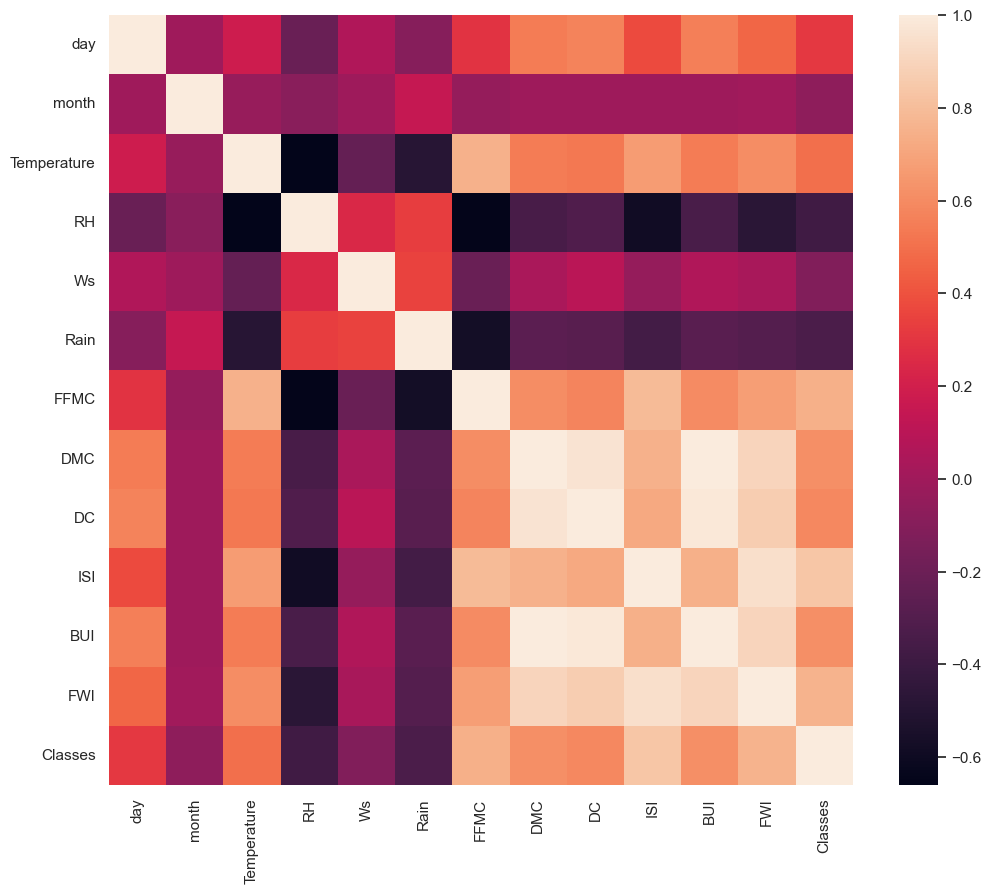

In [5]:
# get the heatmap of the coefficient matrix
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(bejaia.corr())

<Axes: >

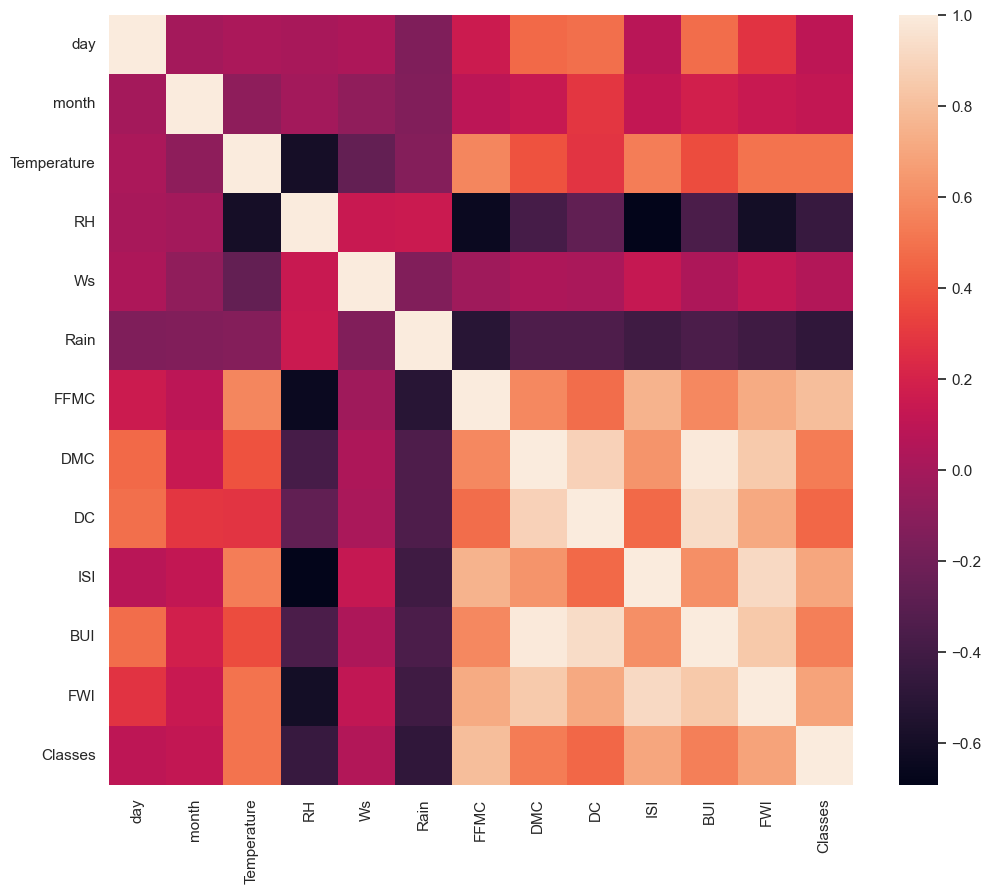

In [6]:
sns.set(rc={'figure.figsize':(12, 10)})
sns.heatmap(sidi.corr())

Based on these two heatmaps we can find a general pattern:
(1) The FWI indices seem to have a strong and positive correlation with the occurence of forest fire
(2) Natural factors like rain and relative humidity seem to have a strong and negative correlation with the occurence of forest fire
(3) Natural factors, like temperature seem to have a middle and positive correlation with the occurence of forest fire.


Another pattern we can identify is that some factors have a correlation coefficient that is so close to 1, which means we may have a multicollinearity that can introduce a bias to our regression model. In this case, we can see the correlation coefficient between BUI and DMC seem to be too high. Instead of making a distinction using naked eyes, we will use algorithim to help us filter our the highly-similar variables.

In [7]:
# separate the dependent variable
ind_bejaia = bejaia.drop('Classes',axis=1)
dep_bejaia = bejaia['Classes']
ind_sidi = sidi.drop('Classes',axis=1)
dep_sidi = sidi['Classes']

# calculate the variance inflation factor for each variable in the dataset
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)

def multico_correction(X, calc_vif):
    corr_matrix = X.corr()
    high_corr_var = np.where(corr_matrix > 0.9)
    high_corr_var=[(corr_matrix.columns[x],corr_matrix.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]

# Remove one variable from each highly correlated pair
    for var1, var2 in high_corr_var:
    # Make sure that both variables are still in the DataFrame
        if var1 in X.columns and var2 in X.columns:
            if calc_vif(X.drop(var1, axis=1))['VIF'].max() < calc_vif(X.drop(var2, axis=1))['VIF'].max():
                print(f"Dropping '{var1}' due to multicollinearity")
                X = X.drop(var1, axis=1)
            else:
                print(f"Dropping '{var2}' due to multicollinearity")
                X = X.drop(var2, axis=1)
        else:
            # If one of the variables has already been dropped, print a message
            if var1 not in X.columns:
                print(f"'{var1}' has already been dropped")
            if var2 not in X.columns:
                print(f"'{var2}' has already been dropped")

    vif = calc_vif(X)
    return(vif)

# run the test for different datasets
print("all factors in bejaia is considered:")
display(multico_correction(ind_bejaia, calc_vif))

print("all factors in sidi is considered: ")
display(multico_correction(ind_sidi, calc_vif))

print("only natural factors in bejaia:")
display(multico_correction(natural_bejaia, calc_vif))

print("only natural factors in sidi: ")
display(multico_correction(natural_sidi, calc_vif))

print("only fwi indices in bejaia")
display(multico_correction(fwi_bejaia, calc_vif))

print("only fwi indices sidi")
display(multico_correction(fwi_sidi, calc_vif))

all factors in bejaia is considered:
Dropping 'DMC' due to multicollinearity
'DMC' has already been dropped
'DMC' has already been dropped
Dropping 'BUI' due to multicollinearity
Dropping 'ISI' due to multicollinearity
'BUI' has already been dropped


,variables,VIF
0,day,6.197537
1,month,41.733293
2,Temperature,131.577772
3,RH,40.313532
4,Ws,38.420171
5,Rain,1.917261
6,FFMC,81.898539
7,DC,10.432277
8,FWI,9.856638


all factors in sidi is considered: 
Dropping 'BUI' due to multicollinearity
'BUI' has already been dropped
Dropping 'ISI' due to multicollinearity


,variables,VIF
0,day,5.982337
1,month,46.651094
2,Temperature,101.747513
3,RH,26.609451
4,Ws,33.245025
5,Rain,1.742094
6,FFMC,118.058363
7,DMC,26.725661
8,DC,11.688857
9,FWI,14.719862


only natural factors in bejaia:


,variables,VIF
0,Temperature,30.218901
1,RH,28.139573
2,Ws,36.286534
3,Rain,1.537807


only natural factors in sidi: 


,variables,VIF
0,Temperature,30.218901
1,RH,28.139573
2,Ws,36.286534
3,Rain,1.537807


only fwi indices in bejaia
Dropping 'DMC' due to multicollinearity
'DMC' has already been dropped
'DMC' has already been dropped
Dropping 'BUI' due to multicollinearity
Dropping 'FWI' due to multicollinearity
'BUI' has already been dropped
'FWI' has already been dropped


,variables,VIF
0,FFMC,3.870092
1,DC,4.253129
2,ISI,6.206116


only fwi indices sidi
Dropping 'DMC' due to multicollinearity
'DMC' has already been dropped
'DMC' has already been dropped
Dropping 'BUI' due to multicollinearity
Dropping 'FWI' due to multicollinearity
'BUI' has already been dropped
'FWI' has already been dropped


,variables,VIF
0,FFMC,3.870092
1,DC,4.253129
2,ISI,6.206116


Based on the tables, we can see that for the FWI factors, the variance inflation factors of FFMC, DC AND ISI all drop to a number below 8 after deleting BUI, FWI and DMC. Therefore, we may consider BUI, FWI and DMC as factors that will trigger multicolinearity and should delete them in the following regression analysis. For natural factors, however, although the relation coefficient is low, they do have a VIF value that is much higher than 10. Such a high value maybe caused by (1) the data are dependent on each other, like rain and humidity, or (2) the variables are correlated in an unlinear way. To discover more about this part, scatter plots among natural factors are drawn for both datasets. However, the correlation between natural factors are inevitable, and cannot be manipulated. Therefore we will not delete any natural factors despite of the high VIF values.

In [8]:
# principal component analysis on natural factors
scaler = StandardScaler()
bejaia_ns = scaler.fit_transform(natural_bejaia)
sidi_ns= scaler.fit_transform(natural_sidi)

# reduce to 2 components
pca = PCA(n_components = 3)
bejaia_pca = pca.fit_transform(bejaia_ns)
sidi_pca = pca.fit_transform(sidi_ns)
display(bejaia_pca)
display(sidi_pca)

array([[-0.06443226,  0.63740759, -0.15763358],
       [-0.25329064, -0.77415786,  0.92241187],
       [ 4.8899698 ,  1.95092307,  2.49119832],
       [ 2.04170142, -2.10351117,  0.26342321],
       [ 0.98857745, -0.87561747, -0.58715547],
       [-0.44992256, -0.63841003,  0.09176567],
       [-1.55531431, -0.2262658 ,  0.73958845],
       [ 0.14368212, -0.68546372, -0.29422604],
       [ 1.51839967, -2.31791894, -0.44234135],
       [ 0.39085845, -1.96613718, -0.02140814],
       [-0.546458  , -0.5650249 ,  0.16885622],
       [ 1.74581741, -0.28659744, -1.22146851],
       [ 2.22472206,  0.40526493, -1.28216652],
       [ 1.13871573,  0.59238197, -1.13867562],
       [ 1.72981618, -0.25766868,  0.1297171 ],
       [ 0.9742835 , -1.86705408, -0.35102363],
       [ 1.16997286, -0.925696  , -0.87948861],
       [ 0.14298328, -1.00927601, -0.23514847],
       [-0.74831081,  0.37550673,  0.2612584 ],
       [ 0.69425611, -0.61729774, -0.59730372],
       [ 0.25493536, -1.15027083, -0.324

array([[-0.06443226,  0.63740759, -0.15763358],
       [-0.25329064, -0.77415786,  0.92241187],
       [ 4.8899698 ,  1.95092307,  2.49119832],
       [ 2.04170142, -2.10351117,  0.26342321],
       [ 0.98857745, -0.87561747, -0.58715547],
       [-0.44992256, -0.63841003,  0.09176567],
       [-1.55531431, -0.2262658 ,  0.73958845],
       [ 0.14368212, -0.68546372, -0.29422604],
       [ 1.51839967, -2.31791894, -0.44234135],
       [ 0.39085845, -1.96613718, -0.02140814],
       [-0.546458  , -0.5650249 ,  0.16885622],
       [ 1.74581741, -0.28659744, -1.22146851],
       [ 2.22472206,  0.40526493, -1.28216652],
       [ 1.13871573,  0.59238197, -1.13867562],
       [ 1.72981618, -0.25766868,  0.1297171 ],
       [ 0.9742835 , -1.86705408, -0.35102363],
       [ 1.16997286, -0.925696  , -0.87948861],
       [ 0.14298328, -1.00927601, -0.23514847],
       [-0.74831081,  0.37550673,  0.2612584 ],
       [ 0.69425611, -0.61729774, -0.59730372],
       [ 0.25493536, -1.15027083, -0.324

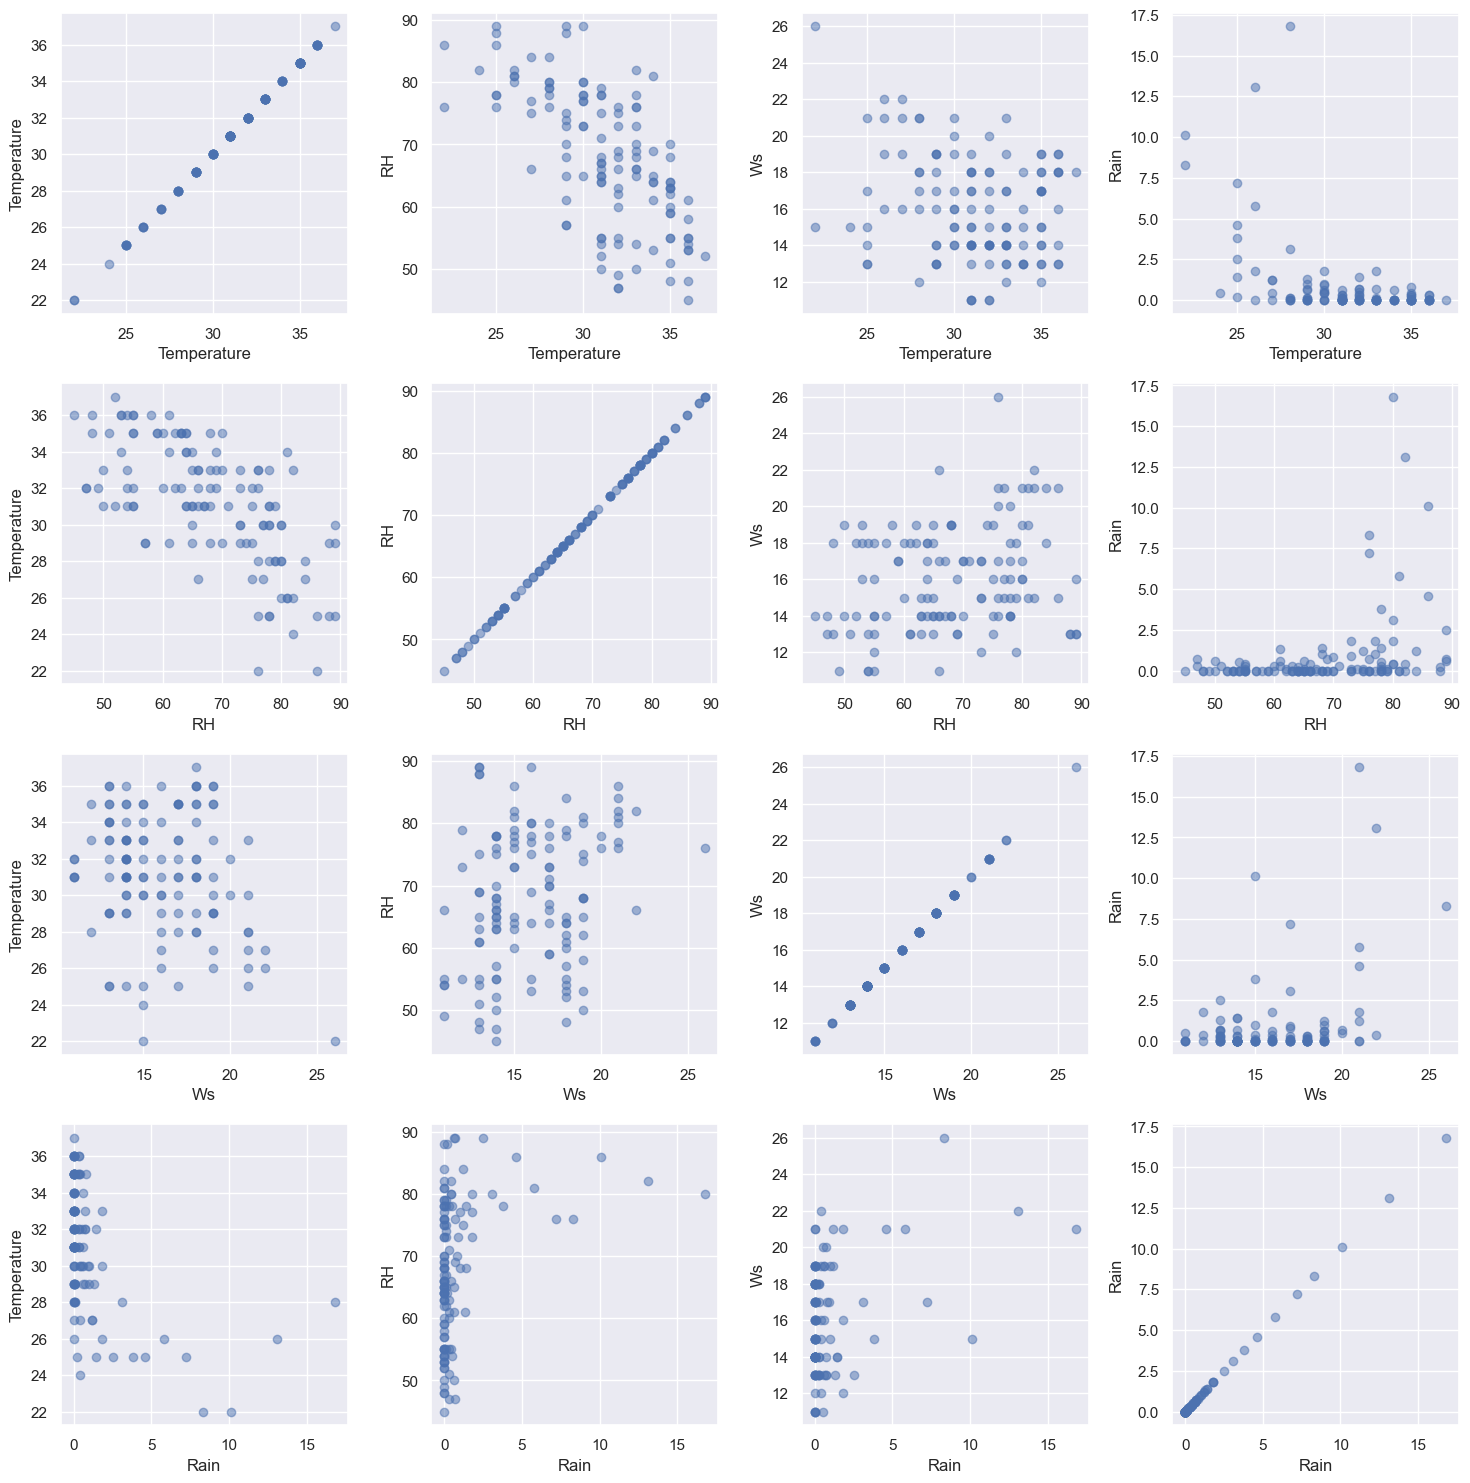

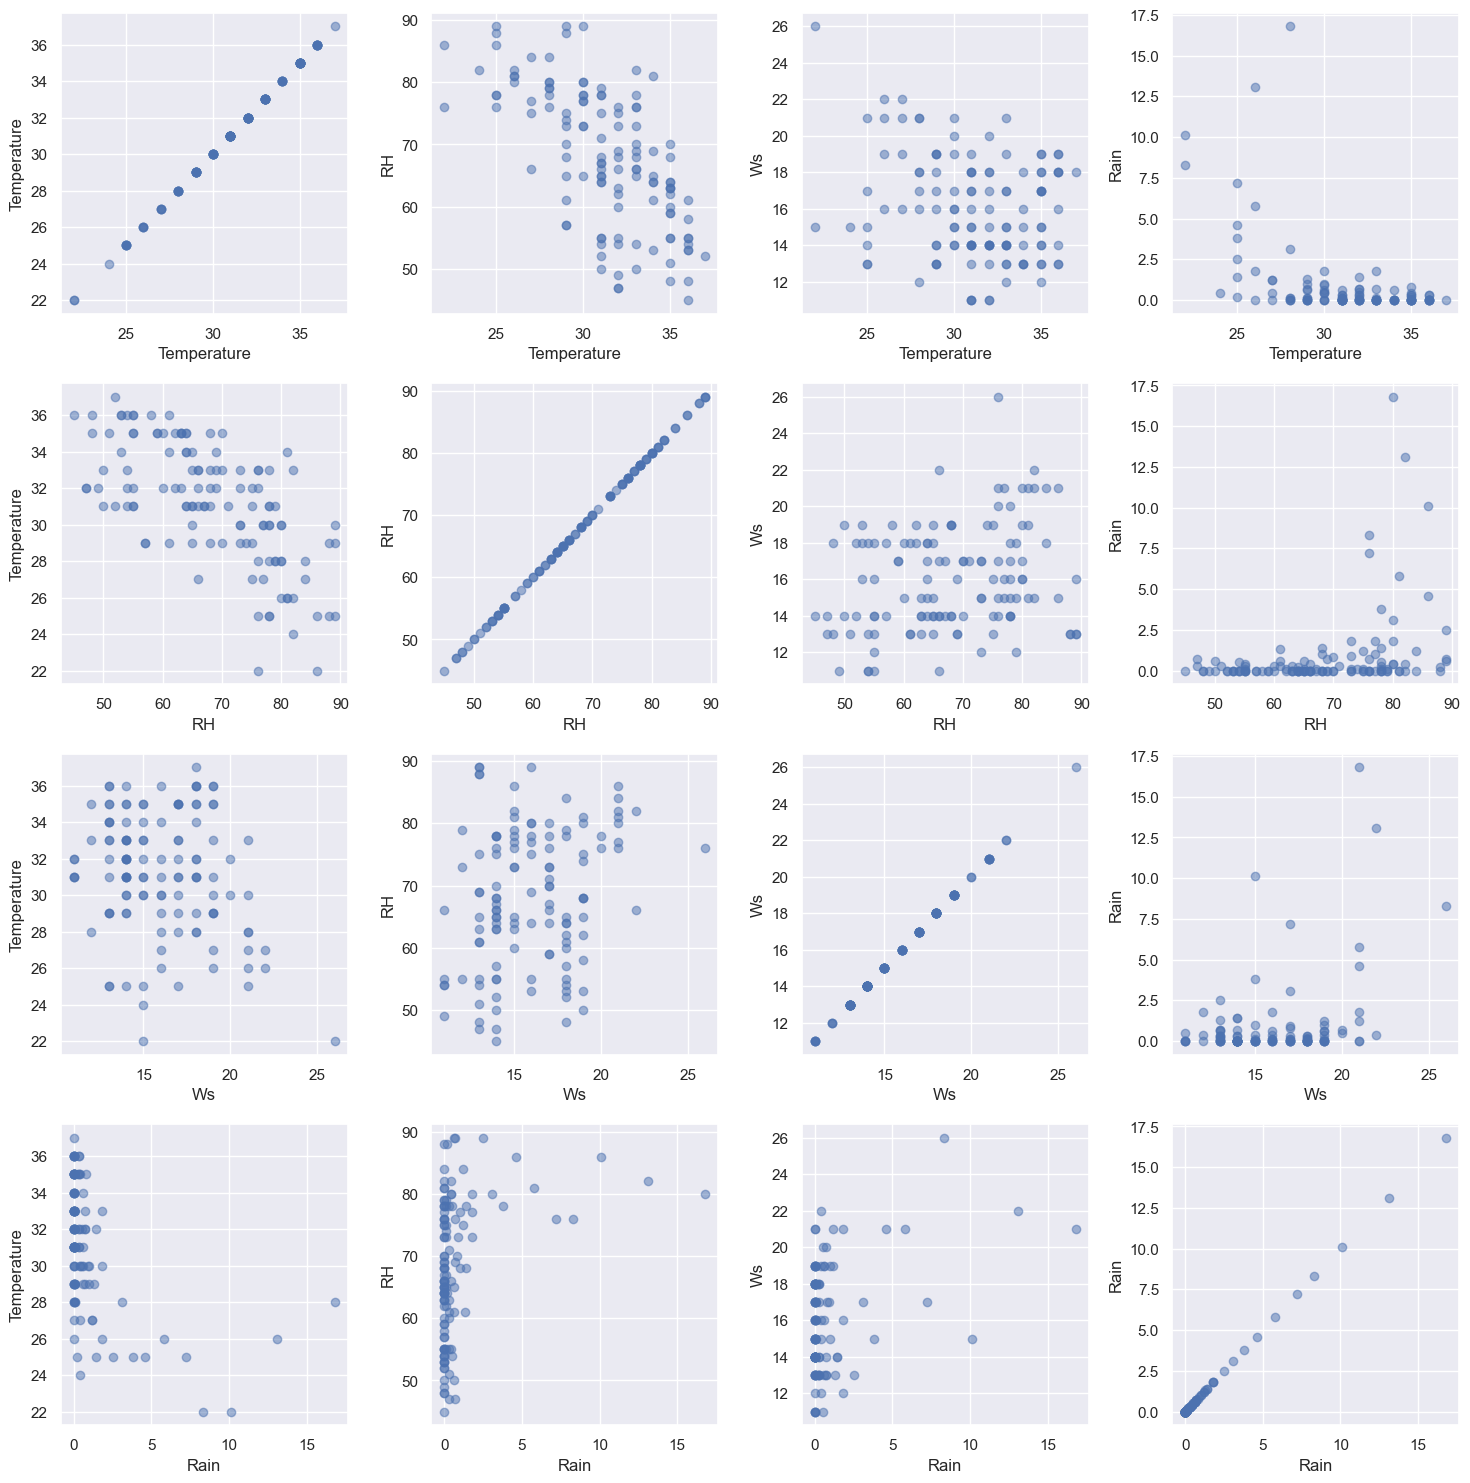

In [9]:
# draw scatter plots among the natural factors
def plot_scatter(df):
    num_vars = len(df.columns)
    fig, axs = plt.subplots(num_vars, num_vars, figsize=(15, 15))

    for i in range(num_vars):
        for j in range(num_vars):
            axs[i, j].scatter(df.iloc[:, i], df.iloc[:, j], alpha=0.5)
            axs[i, j].set_xlabel(df.columns[i])
            axs[i, j].set_ylabel(df.columns[j])
    plt.tight_layout()
    plt.show()
    
plot_scatter(natural_bejaia)
plot_scatter(natural_sidi)

In [10]:
# scale the dataset first (so that all variables'scales are standardized)
scaler = StandardScaler()
bejaia_scale = scaler.fit_transform(ind_bejaia)
sidi_scale = scaler.transform(ind_sidi)

# linear regression part
def linear_regression(ind, dep):
    lin_reg = LinearRegression()
    lin_reg.fit(ind, dep)
    dep_pred = lin_reg.predict(ind)
    mae = mean_absolute_error(dep, dep_pred)
    score = r2_score(dep,dep_pred)
    return mae, score

error_bejaia, r2_bejaia = linear_regression(bejaia_scale, dep_bejaia)
error_sidi, r2_sidi = linear_regression(sidi_scale, dep_sidi)
print(error_bejaia, r2_bejaia)
print(error_sidi, r2_sidi)

0.17611231414390088 0.7833698638484468
0.20401524547342798 0.7135746806324917


In [11]:
# now drop the redundant vairables from the dataset and conduct linear regression again
ind_bejaia.drop(['BUI'],axis = 1,inplace = True)
ind_bejaia.drop(['DMC'],axis = 1,inplace = True)
ind_sidi.drop(['BUI'],axis = 1,inplace = True)
ind_sidi.drop(['DMC'],axis = 1,inplace = True)
bejaia_scale2 = scaler.fit_transform(ind_bejaia)
sidi_scale2 = scaler.transform(ind_sidi)

error_bejaia2, r2_bejaia2 = linear_regression(bejaia_scale2, dep_bejaia)
error_sidi2, r2_sidi2 = linear_regression(sidi_scale2, dep_sidi)
print(error_bejaia2, r2_bejaia2)
print(error_sidi2, r2_sidi2)

0.17535206434576828 0.7830238775660889
0.20812506476518133 0.6989759612200204


Optimization terminated successfully.
         Current function value: 0.550203
         Iterations 6
Optimization terminated successfully.
         Current function value: 0.508600
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Classes   No. Observations:                  122
Model:                          Logit   Df Residuals:                      120
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 Dec 2023   Pseudo R-squ.:                  0.2056
Time:                        15:44:03   Log-Likelihood:                -67.125
converged:                       True   LL-Null:                       -84.498
Covariance Type:            nonrobust   LLR p-value:                 3.754e-09
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
cons

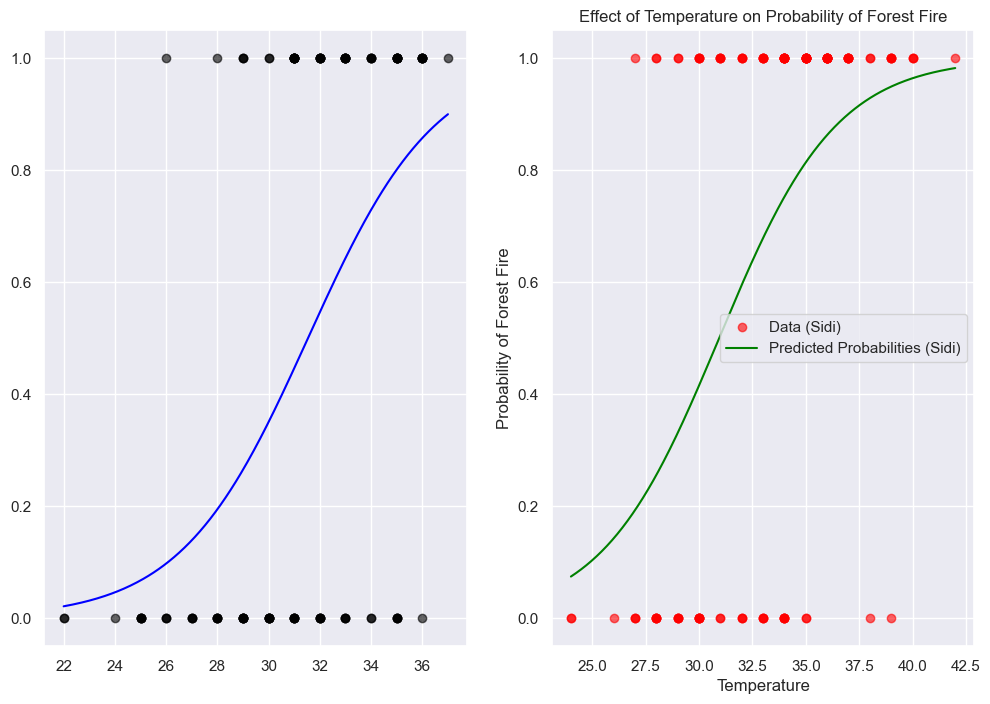

In [12]:
# conduct logistic regression for temperature
Tb = bejaia['Temperature']
Ts = sidi['Temperature']
Tb = sm.add_constant(Tb)
Ts= sm.add_constant(Ts)
depb = bejaia['Classes']
deps = sidi['Classes']

logit_modelb = sm.Logit(depb, Tb)
logit_models = sm.Logit(deps, Ts)
resultb = logit_modelb.fit()
results = logit_models.fit()

# Generating predicted probabilities
temperature_range_b = np.linspace(Tb['Temperature'].min(), Tb['Temperature'].max(), 300)
Tb_temp = sm.add_constant(temperature_range_b)
predicted_probabilities_b = resultb.predict(Tb_temp)

temperature_range_s = np.linspace(Ts['Temperature'].min(), Ts['Temperature'].max(), 300)
Ts_temp = sm.add_constant(temperature_range_s)
predicted_probabilities_s = results.predict(Ts_temp)
print(resultb.summary())
print(results.summary())

# Creating the plot
plt.figure(figsize=(12, 8))

# Plotting for Bejaia
plt.subplot(1, 2, 1)
plt.scatter(Tb['Temperature'], depb, color='black', alpha=0.6, label='Data (Bejaia)')  # Actual data points for Bejaia
plt.plot(temperature_range_b, predicted_probabilities_b, color='blue', label='Predicted Probabilities (Bejaia)')  # Predicted probabilities for Bejaia

# Plotting for Sidi
plt.subplot(1, 2, 2)
plt.scatter(Ts['Temperature'], deps, color='red', alpha=0.6, label='Data (Sidi)')  # Actual data points for Sidi
plt.plot(temperature_range_s, predicted_probabilities_s, color='green', label='Predicted Probabilities (Sidi)')  # Predicted probabilities for Sidi

plt.xlabel('Temperature')
plt.ylabel('Probability of Forest Fire')
plt.title('Effect of Temperature on Probability of Forest Fire')
plt.legend()
plt.show()

In [13]:
# logistic regression for precipitation
Pb = bejaia['Rain']
Ps = sidi['Rain']
Pb = sm.add_constant(Pb)
Ps= sm.add_constant(Ps)
logit_modelrb = sm.Logit(depb, Pb)
logit_modelrs = sm.Logit(deps, Ps)
resultrb = logit_modelrb.fit()
resultrs = logit_modelrs.fit()

rain_range_b = np.linspace(Pb['Rain'].min(), Pb['Rain'].max(), 300)
Pb_rain = sm.add_constant(rain_range_b)
predicted_probabilities_rb = resultrb.predict(Pb_rain)

rain_range_s = np.linspace(Ps['Rain'].min(), Ps['Rain'].max(), 300)
Ts_rain = sm.add_constant(rain_range_s)
predicted_probabilities_rs = results.predict(Ts_rain)
print(resultrb.summary())
print(resultrs.summary())

Optimization terminated successfully.
         Current function value: 0.350289
         Iterations 11
Optimization terminated successfully.
         Current function value: 0.507676
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                Classes   No. Observations:                  122
Model:                          Logit   Df Residuals:                      120
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 Dec 2023   Pseudo R-squ.:                  0.4942
Time:                        15:44:04   Log-Likelihood:                -42.735
converged:                       True   LL-Null:                       -84.498
Covariance Type:            nonrobust   LLR p-value:                 6.288e-20
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const

In [14]:
# logistic regression for relative humidity
Hb = bejaia['RH']
Hs = sidi['RH']
Hb = sm.add_constant(Hb)
Hs= sm.add_constant(Hs)
logit_modelHb = sm.Logit(depb, Hb)
logit_modelHs = sm.Logit(deps, Hs)
resultHb = logit_modelHb.fit()
resultHs = logit_modelHs.fit()

humid_range_b = np.linspace(Hb['RH'].min(), Hb['RH'].max(), 300)
Hb_humid = sm.add_constant(humid_range_b)
predicted_probabilities_Hb = resultrb.predict(Hb_humid)

humid_range_s = np.linspace(Hs['RH'].min(), Hs['RH'].max(), 300)
Hs_humid = sm.add_constant(humid_range_s)
predicted_probabilities_Hs = results.predict(Hs_humid)
print(resultHb.summary())
print(resultHs.summary())

Optimization terminated successfully.
         Current function value: 0.617602
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.542810
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:                Classes   No. Observations:                  122
Model:                          Logit   Df Residuals:                      120
Method:                           MLE   Df Model:                            1
Date:                Sun, 17 Dec 2023   Pseudo R-squ.:                  0.1083
Time:                        15:44:04   Log-Likelihood:                -75.347
converged:                       True   LL-Null:                       -84.498
Covariance Type:            nonrobust   LLR p-value:                 1.885e-05
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const 

C:\Users\tangx\miniconda3\envs\progLab\lib\site-packages\statsmodels\discrete\discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))
